# Autoencoder CNN for Time Series Denoising

As a second example, we will create another convolutional neural network (CNN), but this time for time series denoising. The type of neural network architecture we ar using for that purpose is the one of an **autoencoder**. 

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical,plot_model

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({'font.size': 18,
                     'axes.titlesize': 20,
                     'axes.labelsize': 20,
                     'axes.labelpad': 1,
                     'lines.linewidth': 2,
                     'lines.markersize': 10,
                     'xtick.labelsize' : 18,
                     'ytick.labelsize' : 18,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in'
                    })

## Autoencoder Structure and Purpose

Autoencoders are a type of unsupervised neural network. They do not use labeled classes or any labeled data. They are in general used to 

- Accept an input set of data 
- Internally compress the input data into a latent-space representation 
- Reconstruct the input data from this latent representation


An autoencoder is having two components:

- **Encoder:** Accepts the input data and compresses it into the latent-space. If we denote our input data as $x$ and the encoder as $E$, then the output latent-space representation, $s$, would be $s = E(x)$.
- **Decoder:** The decoder is responsible for accepting the latent-space representation $s$ and then reconstructing the original input. If we denote the decoder function as $D$ and the output of the detector as $o$, then we can represent the decoder as $o = D(s)$.


Also not originally developed to denoise data, we will construct an autoencoder, which is learning to denoise a time series. Autoencoders are also often used to remove noise from images before applying a CNN to image classification. 

The shape of the autoencoder network could be the following. We take a timeseries as input, which could contain 1024 data points. The datapoints are then compressed down to only 32 datapoints in the encoder steps and then decoded back into the original 1024 datapoint. Due to the compression and the action of the weights, a part of the noise is removed. In our example below, we will represent the autoencoder with a CNN.

![autoencoder](autoencoder.png)

## Data Generation

We will apply (and train) the network to a data series containing a noisy sine wave. In a first step, we will generate data for that purpose. For the convolutional network, our data shall be two dimensional. We therefore squeeze our linear timeseries in a two dimensional array with 28 x 28 data points.

In [30]:
data_len=28**2

We create two series

- a noisy sample with noise, noisy_input
- a pure series without noise, pure_input

Overall we will generate 100000 datasets. We will take from that data the training, the testing and the validation data.

In [21]:
noisy_sample=np.zeros(data_len)
pure_sample=np.zeros(data_len)

The following cell will generate all the data based on a sine function and add quite a lot of noise. It will also normalize the input data to have all in a restructed value range. 

In [31]:
y_val_noisy_r = []
y_val_pure_r = []
x_val_noisy=np.arange(0,data_len)

for i in range(100000):
    pure_sample=np.sin(10*np.pi*x_val_noisy/data_len+np.random.randint(100))
    noisy_sample=pure_sample+np.random.normal(0,1,data_len)
    pure_sample=(pure_sample-np.min(noisy_sample))/(np.max(noisy_sample) - np.min(noisy_sample))
    noisy_sample = (noisy_sample - np.min(noisy_sample)) / (np.max(noisy_sample) - np.min(noisy_sample))
    
    tmp_n=np.copy(noisy_sample.reshape(28,28))
    tmp_p=np.copy(pure_sample.reshape(28,28))
    y_val_noisy_r.append(tmp_n)
    y_val_pure_r.append(tmp_p)
    
    
y_val_noisy_r   = np.array(y_val_noisy_r)
y_val_pure_r    = np.array(y_val_pure_r)
noisy_input     = y_val_noisy_r.reshape((y_val_noisy_r.shape[0], y_val_noisy_r.shape[1], y_val_noisy_r.shape[2], 1))
pure_input      = y_val_pure_r.reshape((y_val_pure_r.shape[0], y_val_pure_r.shape[1], y_val_pure_r.shape[2], 1))    

The plot below just depicts a random sample of our data.

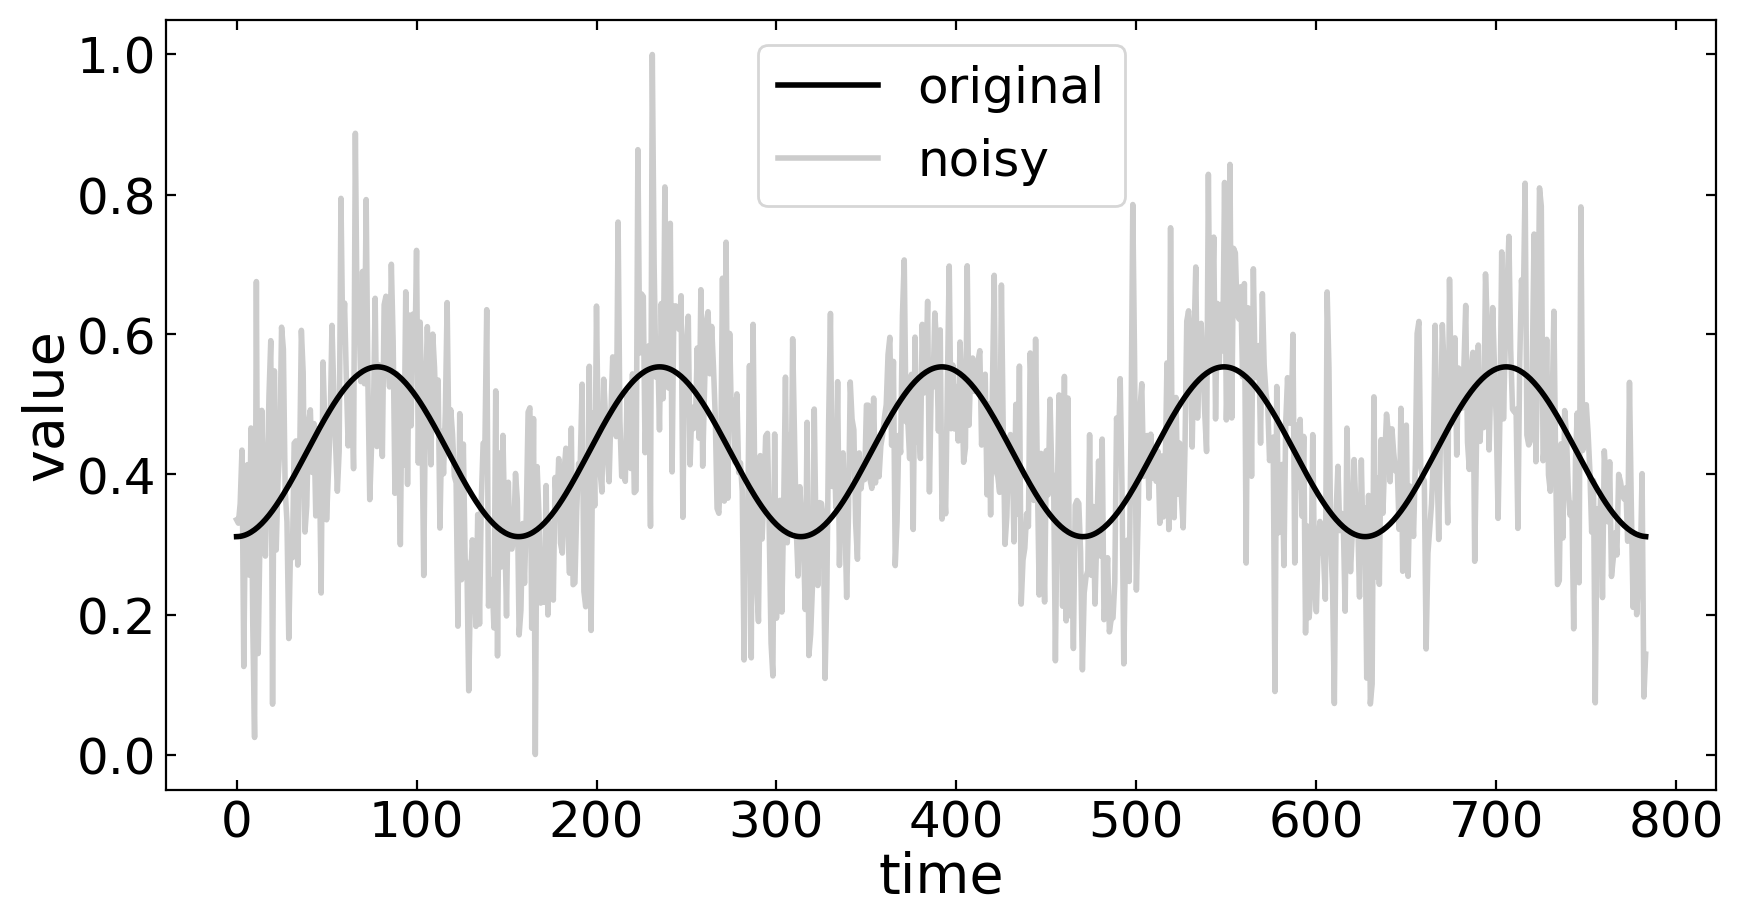

In [39]:
n=np.random.randint(10000)
plt.figure(figsize=(10,5))
plt.plot(y_val_pure_r[n].reshape(data_len,1),'k',label='original')
plt.plot(y_val_noisy_r[n].reshape(data_len,1),'k',alpha=0.2,label='noisy')
plt.legend()
plt.xlabel('time')
plt.ylabel('value')
plt.show()

## Create the Autoencoder network

This creates an autoencoder. Two convolutional layers for the encoding and two for decoding.

In [40]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import RMSprop

import math

### Define model data

In [25]:
# Model configuration
width, height = 28, 28
input_shape = (width, height, 1)
batch_size = 150
no_epochs = 5
max_norm_value = 2.0
train_test_split = 0.3
validation_split = 0.2

In [41]:
# Train/test split
percentage_training = math.floor((1 - train_test_split) * len(noisy_input))
noisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]
pure_input, pure_input_test = pure_input[:percentage_training], pure_input[percentage_training:]

### Encoder/Decoder Setup

The next cell defines the actual autoencoder network. The network consists of a


**encoder**
- 28 x 28 datapoints input
- convolutional layer  with 32 kernels of 3 x 3 size and ReLU activation
- pooling layer using the maxima of a 2 x 2 matrix
- convolutional layer  with 64 kernels of 3 x 3 size and ReLU activation
- pooling layer using the maxima of a 2 x 2 matrix
- convolutional layer  with 128 kernels of 3 x 3 size and ReLU activation



**decoder**
- convolutional layer  with 128 kernels of 3 x 3 size and ReLU activation
- upsampling layer increasing the data by a factor of 2 x 2
- convolutional layer  with 64 kernels of 3 x 3 size and ReLU activation
- upsampling layer increasing the data by a factor of 2 x 2
- convolutional layer with 1 kernels of 3 x 3 size and ReLU activation

The summary function shows the parameters of the network, especially the output shape of each layer.

In [42]:
model=Sequential()

#encoder
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')) 
model.add(MaxPooling2D(pool_size=(2, 2)))          
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
          
#decoder
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))          
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))          
model.add(Conv2D(1, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', padding='same'))      

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 128)        

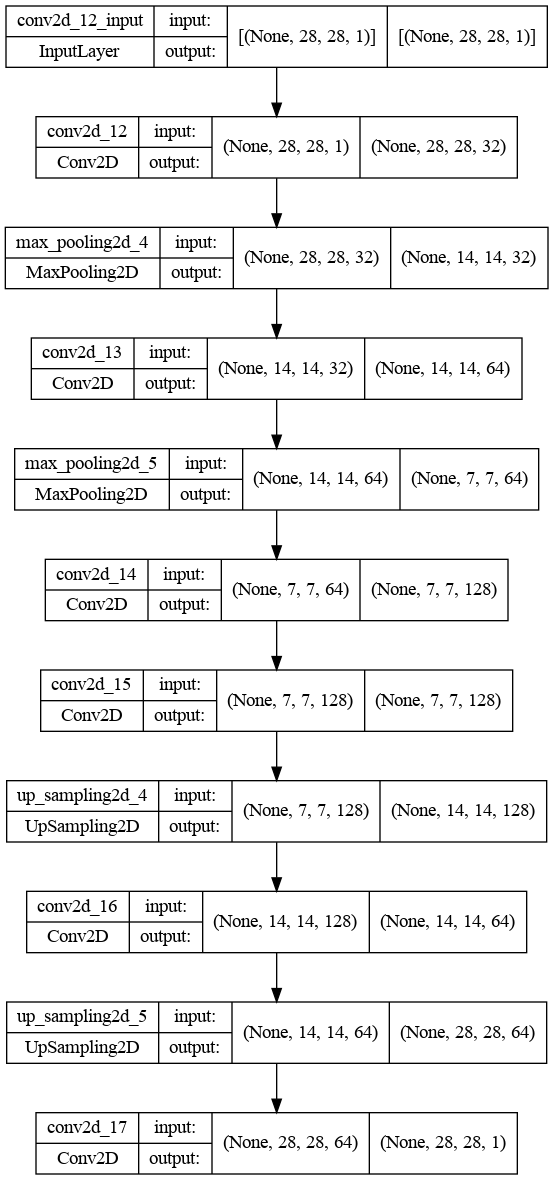

In [43]:
plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

### Training the encoder

The only thing we have to do now, is to compile the model and train the network on our generated data.

In [44]:
# Compile and fit data
model.compile(optimizer=RMSprop(), loss='mean_squared_error')
model.fit(noisy_input, pure_input,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)

Epoch 1/5


2023-07-11 15:17:25.371248: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 175616000 exceeds 10% of free system memory.
2023-07-11 15:17:25.470598: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 175616000 exceeds 10% of free system memory.


374/374 [==============================] - 73s 193ms/step - loss: 0.0193 - val_loss: 0.0063
Epoch 2/5
374/374 [==============================] - 73s 194ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 3/5
374/374 [==============================] - 73s 194ms/step - loss: 0.0016 - val_loss: 7.3326e-04
Epoch 4/5
374/374 [==============================] - 73s 195ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 5/5
374/374 [==============================] - 73s 194ms/step - loss: 0.0011 - val_loss: 0.0013


## Reconstruction of the Data

After 5 episodes of training, we are ready to test the model on a testing example of our data. That means we supply some timeseries that is unknown to the network. The cell below is doing 2000 reconstructions at a time. 

In [45]:
num_reconstructions = 2000
samples = noisy_input_test[:num_reconstructions]
reconstructions = model.predict(samples)

Having done all these 2000 reconstructions, we can select an arbitrary one to plot the noisy input data together with the denoised data. 

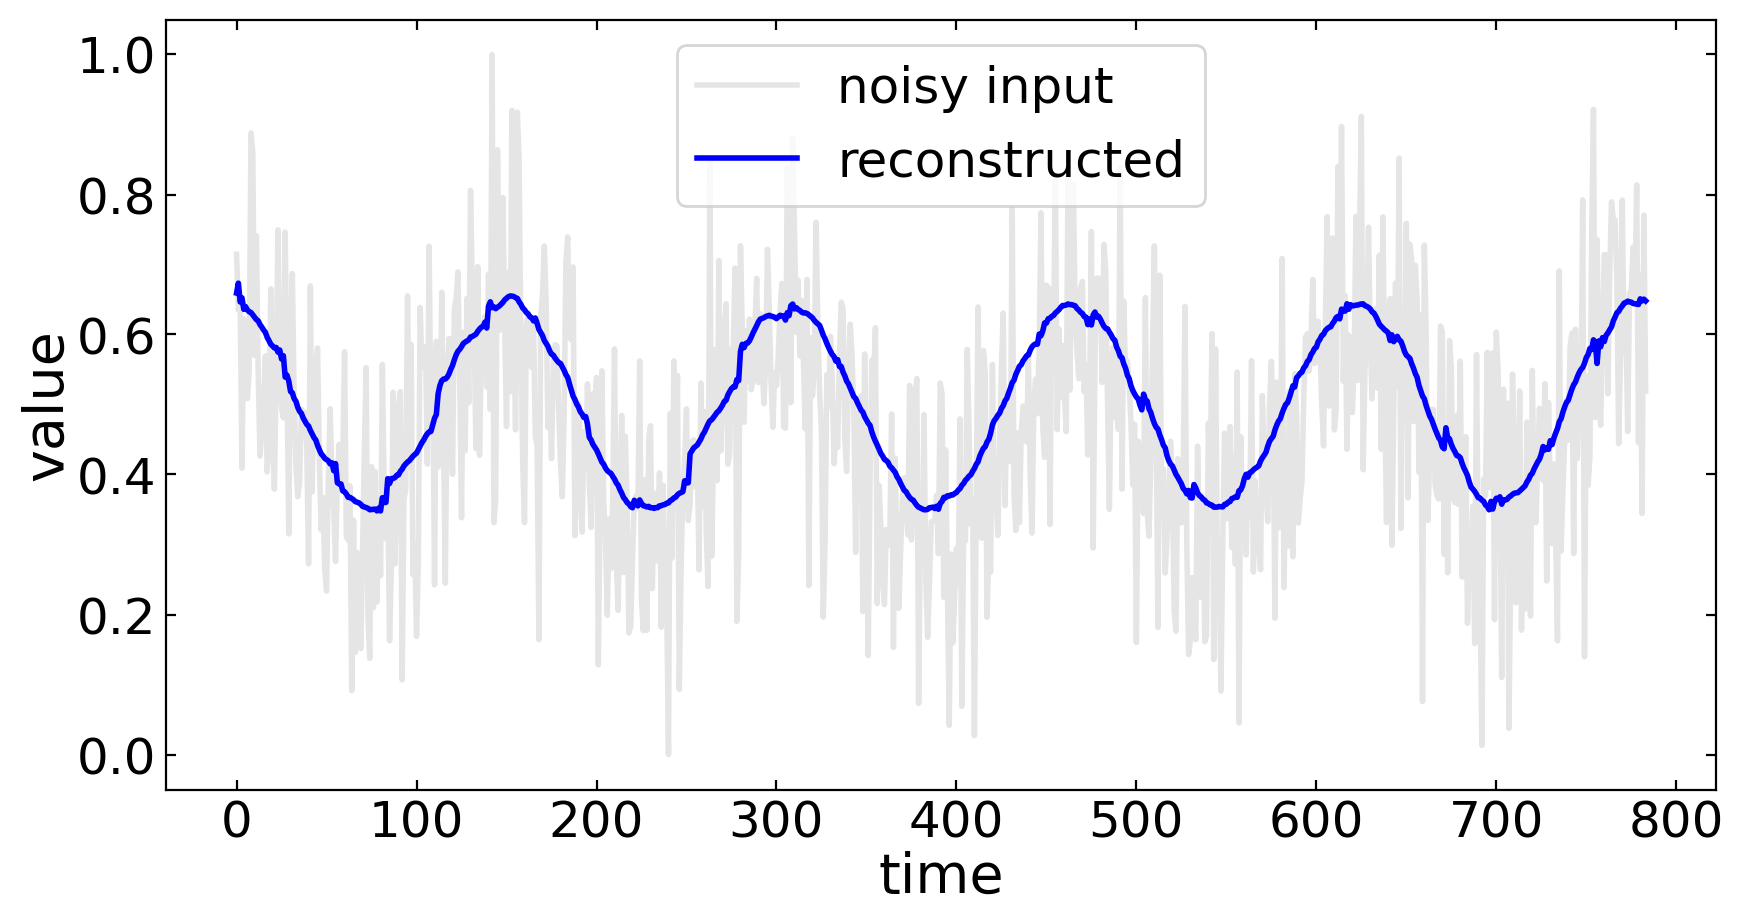

In [51]:
n=np.random.randint(num_reconstructions)
plt.figure(figsize=(10,5))
plt.plot(samples[n].reshape(data_len,1),'k',alpha=0.1,label='noisy input')
plt.plot(reconstructions[n].reshape(data_len,1),'b',alpha=1,label='reconstructed')
plt.legend()
plt.xlabel('time')
plt.ylabel('value')
plt.show()